# Evaluation with synthetic data

In [13]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
adata = sc.read_h5ad("../data/synthetic_dataset.hda5")
adata

AnnData object with n_obs × n_vars = 1000 × 99
    obs: 'transition', 'time_transition_cell', 'sim_time', 'state', 'n_counts_all', 'leiden', 'splitted_transition', 'cluster'
    var: 'n_counts', 'mean', 'std'
    uns: 'cluster_colors', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'splitted_transition_colors', 'state_colors', 'state_trajectory', 'transition_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
    varp: 'global', 'sA-sB', 'sB-sBmid', 'sBmid-sC', 'sBmid-sD', 'sBurn-sA', 'sC-sEndC', 'sD-sEndD'

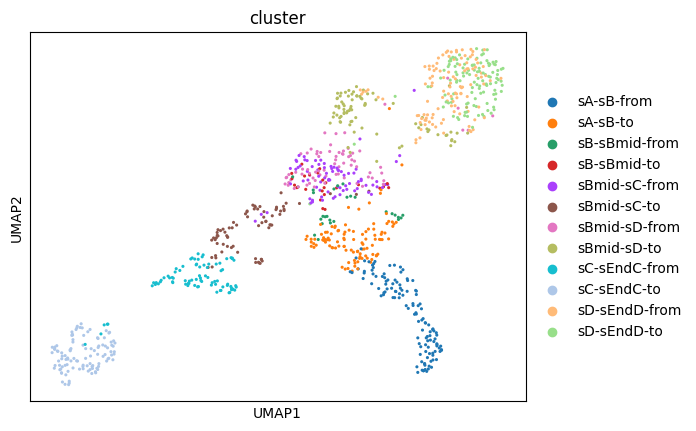

In [15]:
sc.pl.umap(adata, color="cluster", size=20)

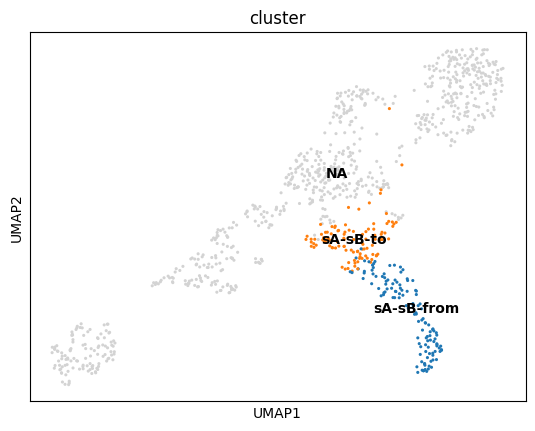

In [16]:
label_cluster_a = "sA-sB-from"
label_cluster_b = "sA-sB-to"

cluster = adata.obs["cluster"].copy()

mask_obs = adata.obs["cluster"].isin([label_cluster_a, label_cluster_b])
sc.pl.umap(adata, color="cluster", mask_obs=mask_obs, size=20, legend_loc="on data")
# the plotting overwrites clusters, so assign it back
# I do not know if this is a bug from scanpy. I cannot imagine this is wanted behavour.
adata.obs["cluster"] = cluster

In [17]:
from methods import calculate_mean_change_similarity_matrix, calculate_relation_mean_change_matrix

similarity_metric = calculate_mean_change_similarity_matrix

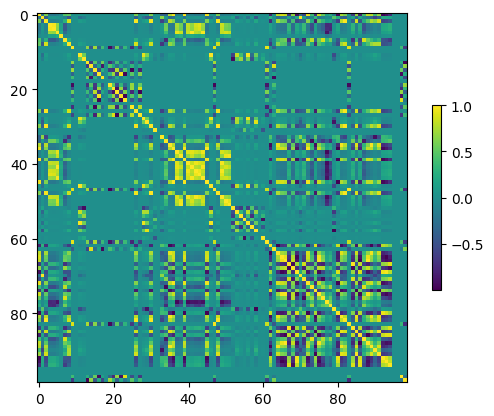

In [18]:
from data_utils import extract_samples_of_cell_cluster

df_cells = adata.to_df()
clusters = adata.obs["cluster"]
samples_cluster_a = extract_samples_of_cell_cluster(df_cells, clusters, label_cluster_a)
samples_cluster_b = extract_samples_of_cell_cluster(df_cells, clusters, label_cluster_b)

similarity_matrix = similarity_metric(samples_cluster_a, samples_cluster_b)
sc.pl.matrix(similarity_matrix)

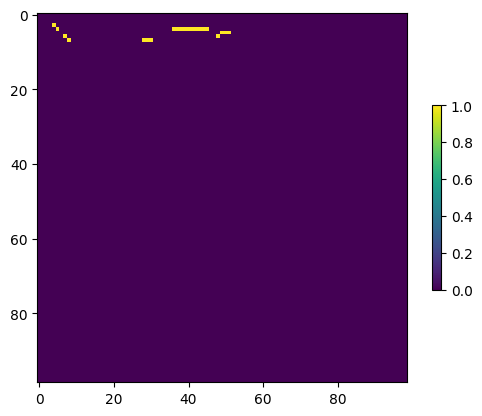

In [19]:
transition_grn = adata.varp["sA-sB"]
sc.pl.matrix(transition_grn != 0)

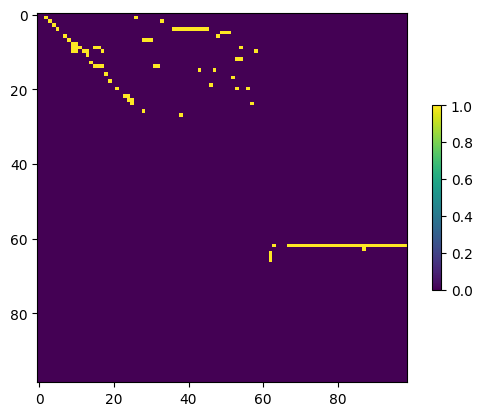

In [20]:
global_grn = adata.varp["global"]
sc.pl.matrix(global_grn != 0)

In [21]:
binary_grn_mask = np.abs(transition_grn) > 0
active_gene_indices = np.argwhere(binary_grn_mask)

similarity_values = similarity_matrix[binary_grn_mask]
grn_values = transition_grn[binary_grn_mask]


We get vastly different results if we use for the binary_grn_mask the global_grn. So similarity, does give some decent results for refinement, but only for an already transitional grn. This is due to the method (mean difference) that does really no good job in saying if a regulation is active. But maybe activation score can be used for this.

## Evaluation prediction of direction

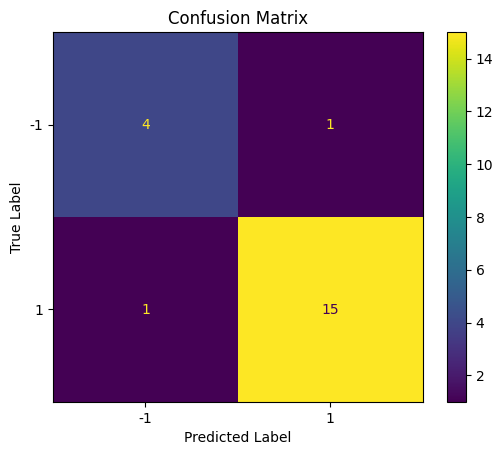

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

directions_true = np.sign(grn_values)
directions_pred = np.sign(similarity_values)

assert not np.any(directions_pred == 0), "One of the predictions is 0"

labels = [-1, 1]

ConfusionMatrixDisplay.from_predictions(directions_true, directions_pred, labels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
from sklearn.metrics import balanced_accuracy_score, classification_report

score = balanced_accuracy_score(directions_true, directions_pred)
print(f"balanced accuracy score: {score}\n")

print("Classification report:\n")
print(classification_report(directions_true, directions_pred, zero_division=0.))

balanced accuracy score: 0.86875

Classification report:

              precision    recall  f1-score   support

        -1.0       0.80      0.80      0.80         5
         1.0       0.94      0.94      0.94        16

    accuracy                           0.90        21
   macro avg       0.87      0.87      0.87        21
weighted avg       0.90      0.90      0.90        21



## Evaluation ranking of weights

In [24]:
from scipy.stats import spearmanr

alpha = 0.05
spearman_coeff, p_value = spearmanr(similarity_values, grn_values)
print(f"Spearman coeff: {spearman_coeff}")
print(f"p_value for Null Hypothesis, that both rankings are not correlated: {p_value}")
if p_value < alpha:
    print("We reject the Null Hypothesis")
else:
    print("The Null Hypothesis holds")

Spearman coeff: 0.7511440500485019
p_value for Null Hypothesis, that both rankings are not correlated: 8.697013407512725e-05
We reject the Null Hypothesis


In [25]:
driver_gene_names = df_cells.columns[active_gene_indices[:, 0]]
target_gene_names = df_cells.columns[active_gene_indices[:, 1]]

grn_weight_names = np.strings.add(driver_gene_names + "->", target_gene_names)

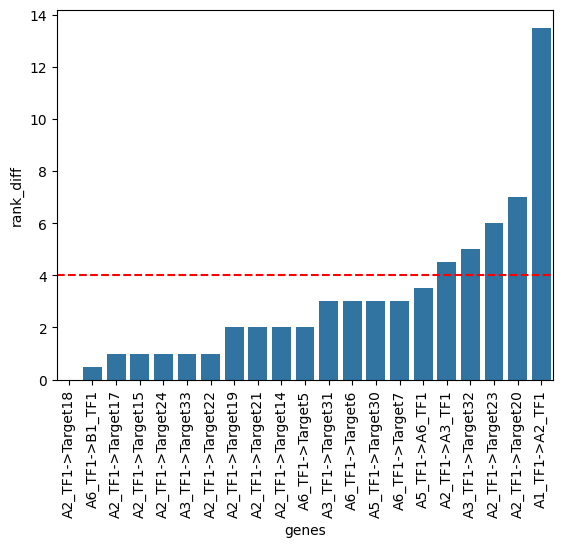

In [ ]:
from scipy.stats import rankdata
import seaborn as sns

grn_ranks = rankdata(grn_values, method='average')
similarity_ranks = rankdata(similarity_values, method='average')

df_ranks = pd.DataFrame({
    "rank_pred": similarity_ranks,
    "rank_true": grn_ranks,
    "values_pred": similarity_values,
    "values_true": grn_values,
    "rank_diff": np.abs(similarity_ranks - grn_ranks),
    "gene_interactions": grn_weight_names
})


# threshold means, that a rank_diff is good if it is not greater than 10% of the ranking length
threshold_rank_diff = int(df_ranks.shape[0] * 0.2)

sns.barplot(df_ranks.sort_values("rank_diff"), x="gene_interactions", y="rank_diff")
plt.axhline(y=threshold_rank_diff, color='red', linestyle='--', label='Threshold')
plt.xticks(rotation=90)
plt.show()

In [28]:
df_ranks.sort_values("rank_true")

,rank_pred,rank_true,values_pred,values_true,rank_diff,genes
5,1.0,1.0,-0.199697,-42.057050,0.0,A2_TF1->Target18
16,5.0,2.0,-0.018637,-24.883327,3.0,A5_TF1->Target30
11,2.0,3.0,-0.194743,-10.698090,1.0,A2_TF1->Target24
18,6.0,4.0,0.026574,-1.315294,2.0,A6_TF1->Target5
2,3.0,5.0,-0.194015,-1.193104,2.0,A2_TF1->Target14
0,21.0,7.5,0.972326,1.000000,13.5,A1_TF1->A2_TF1
15,4.0,7.5,-0.065664,1.000000,3.5,A5_TF1->A6_TF1
1,12.0,7.5,0.663610,1.000000,4.5,A2_TF1->A3_TF1
17,8.0,7.5,0.239805,1.000000,0.5,A6_TF1->B1_TF1
19,7.0,10.0,0.047066,1.058860,3.0,A6_TF1->Target6


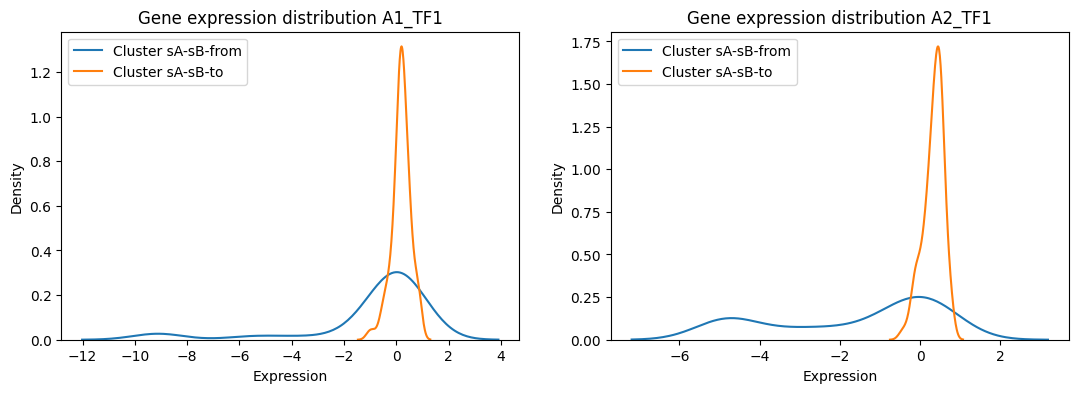

In [29]:
from plotting import display_gene_expression_distribution

_, ax = plt.subplots(1, 2, figsize=(13, 4))

index_biggest_diff = np.argmax(df_ranks["rank_diff"])
driver_gene = driver_gene_names[index_biggest_diff]
target_gene = target_gene_names[index_biggest_diff]

display_gene_expression_distribution(adata, driver_gene, clusters=[label_cluster_a, label_cluster_b], ax=ax[0])
display_gene_expression_distribution(adata, target_gene, clusters=[label_cluster_a, label_cluster_b], ax=ax[1])

I guess In cluster sA-sB-from A2_TF1 has at the moment a shift, where some cells already begin to express the gene in fast rate, while others are still inactive. Resulting in a bimodal distribution. Therefore the arithmetic mean is not at the same place as the peak. Not even near. Consider looking only at the peak, to make the method more robust. 

# Evaluation Activation Score

In [30]:
true_active_driver_genes = np.zeros((transition_grn.shape[0],))
active_drivers, active_targets = np.nonzero(transition_grn)
true_active_driver_genes[active_drivers] = 1

In [31]:
from methods import activation_score_of_group

target_mean_expressions = samples_cluster_b.mean().to_numpy()

activity_genes = activation_score_of_group(target_mean_expressions, similarity_matrix)


# Remove housekeeping genes from results, because they are not included in the transition grn
hk_gene_mask = samples_cluster_a.columns.str.contains("HK")

true_active_driver_genes = true_active_driver_genes[~hk_gene_mask]
activity_genes = activity_genes[~hk_gene_mask]

df_activity_genes = pd.DataFrame({ "activity": activity_genes }, index=samples_cluster_a.columns[~hk_gene_mask])


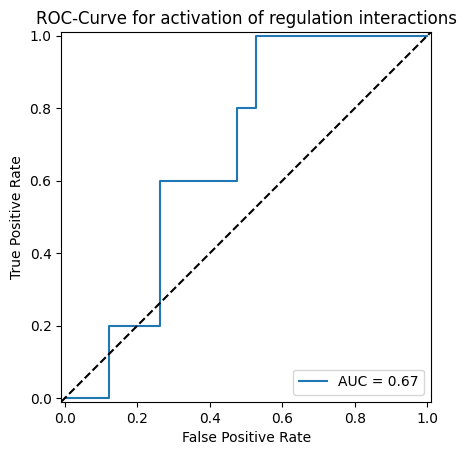

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(true_active_driver_genes, activity_genes)
roc_auc = roc_auc_score(true_active_driver_genes, activity_genes)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title("ROC-Curve for activation of regulation interactions")
plt.axline((0, 0), (1, 1), color='black', linestyle='--', label='random')

In [33]:
display(samples_cluster_b.mean().sort_values().tail(30))

A1_TF1       0.186294
HK43         0.206680
Target17     0.225166
Target20     0.227328
HK13         0.235684
Target23     0.240835
Target33     0.253492
HK42         0.263583
A3_TF1       0.271339
Target32     0.272456
Target21     0.296621
Target15     0.317526
Target19     0.318541
A2_TF1       0.332889
Target31     0.342716
Target22     0.344379
Target27     0.344983
Burn3_TF1    0.368501
HK30         0.422080
Target1      0.450594
HK44         0.479892
Target30     0.550127
Target48     0.586426
Target36     0.600085
HK26         0.628099
B4_TF1       0.640842
Target35     0.748978
B5_TF1       0.766542
Target46     0.803125
Target5      1.374070
dtype: float32

The target genes and driver genes from the active module from the transition before (Burn Phase) have still high values. I have to inspect if that is by design modelled like this. Maybe they just degrade slow in the simulation. Or they programmed nothing to deactivate them again.

Also very likely, the model assigns high activity values to target genes, because I have a similarity matrix as grn and a similarity matrix is symmetric.

Also using a refined grn would be better, but then I have problems with roc, because of sparse matrix. Roc does not expect that most of the scores have the same value. Resulting in weird behavior.

Also the activation score does probably not consider, that some genes may just have always a quite high expression rate. Resulting in them to be always active. Not sure how this is in biology. Maybe some genes have never a high expression rate, but at some times a higher one => peak? 

## Inspection if assumptions of model are violated

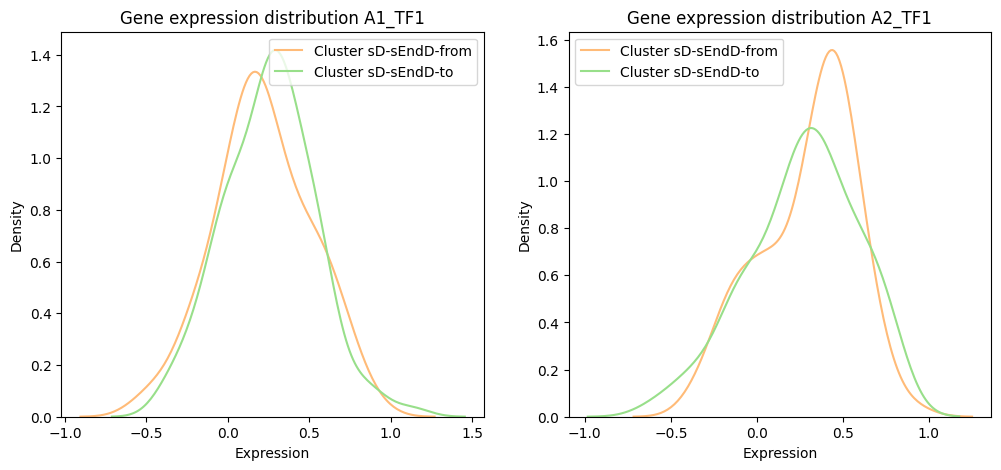

Weight: 1.0


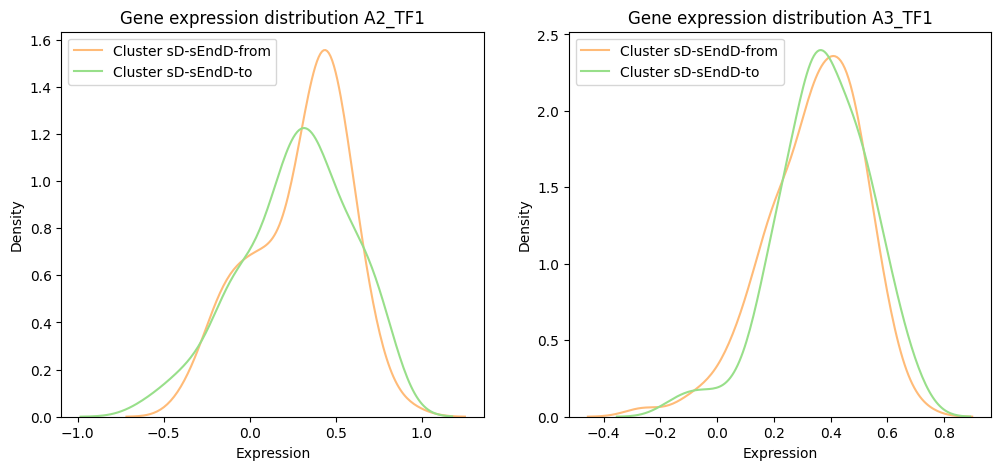

Weight: 1.0


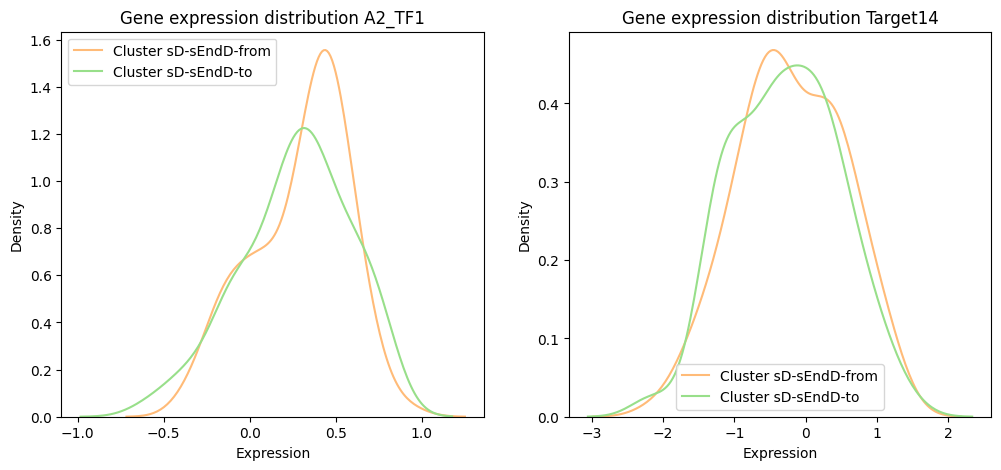

Weight: -1.193104


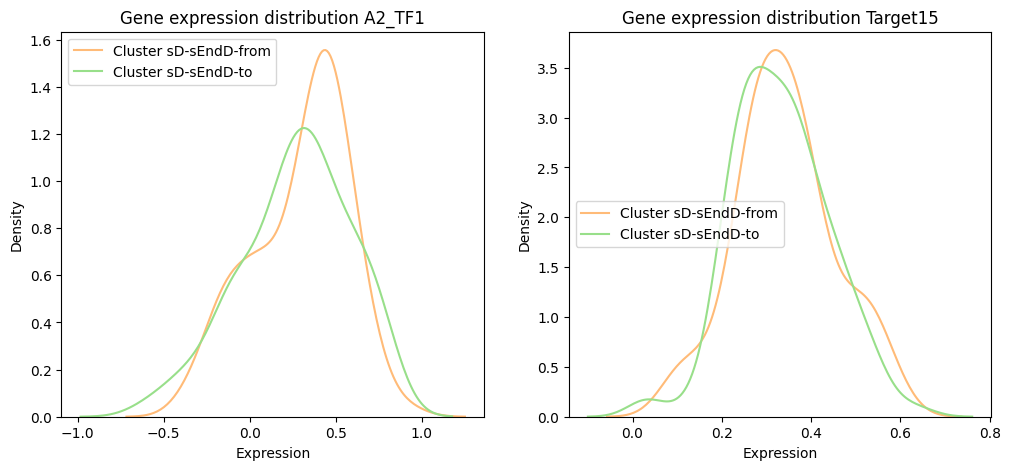

Weight: 7.733148


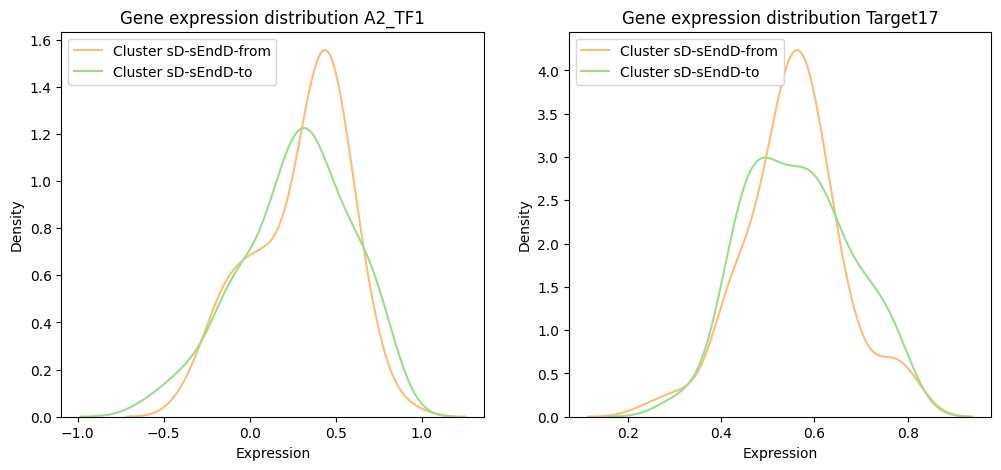

Weight: 1.394834


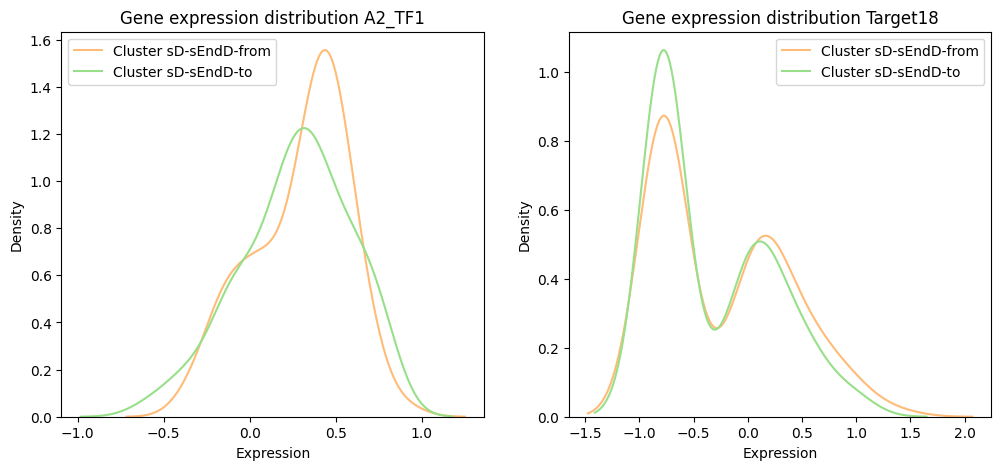

Weight: -42.05705


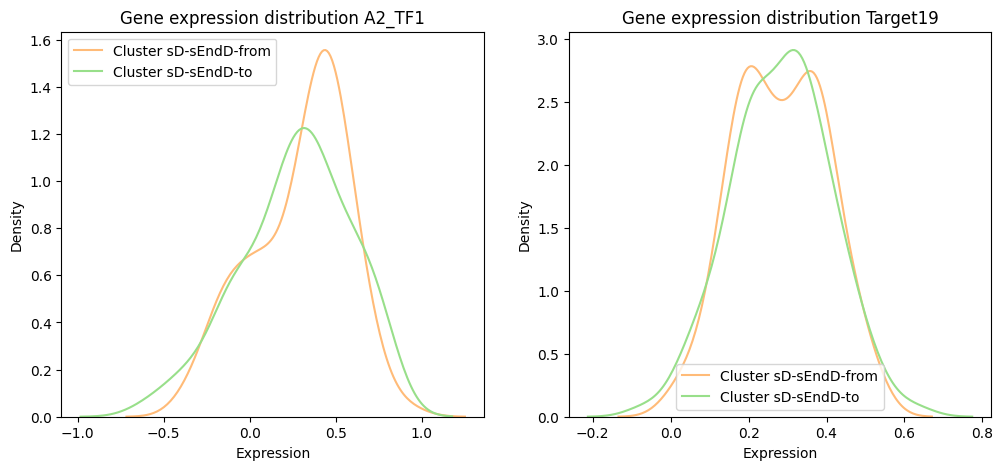

Weight: 2.409792


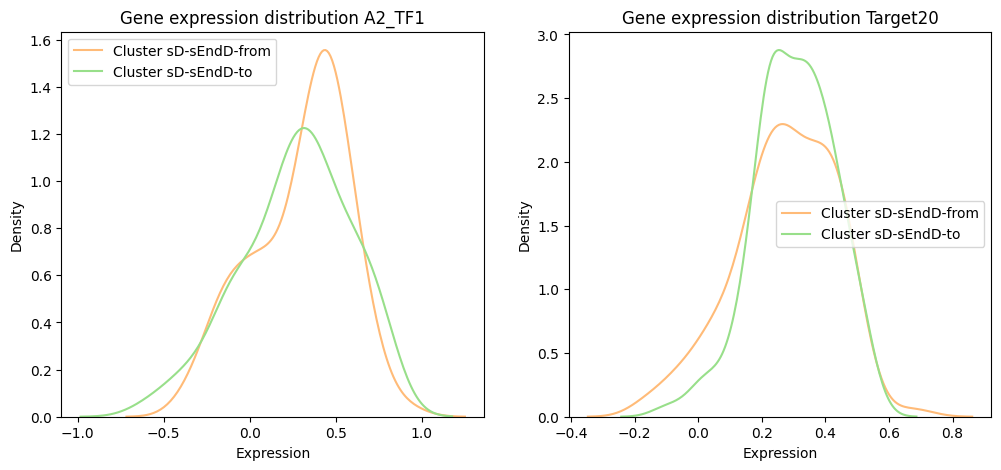

Weight: 32.300583


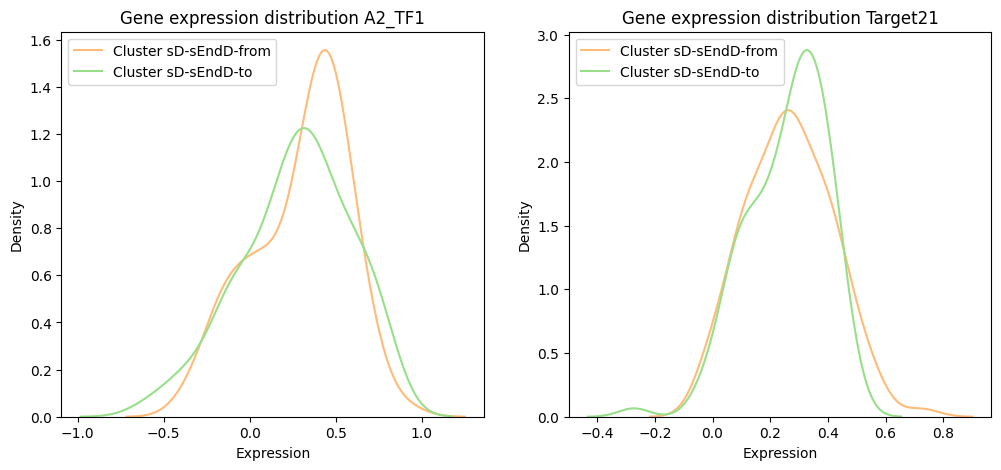

Weight: 8.290418


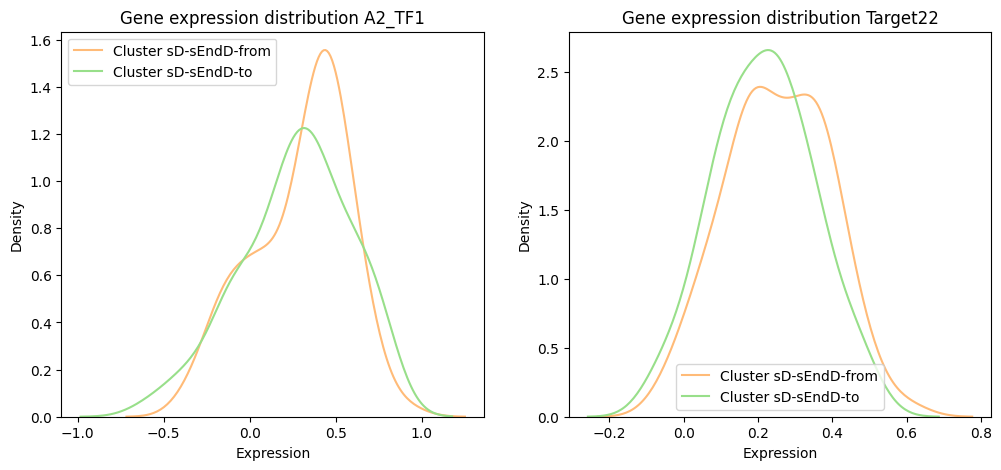

Weight: 66.65727


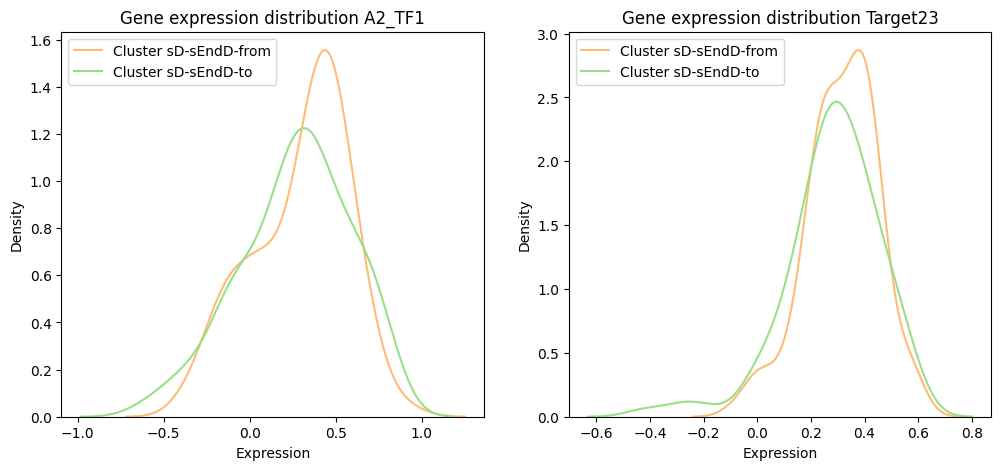

Weight: 43.078833


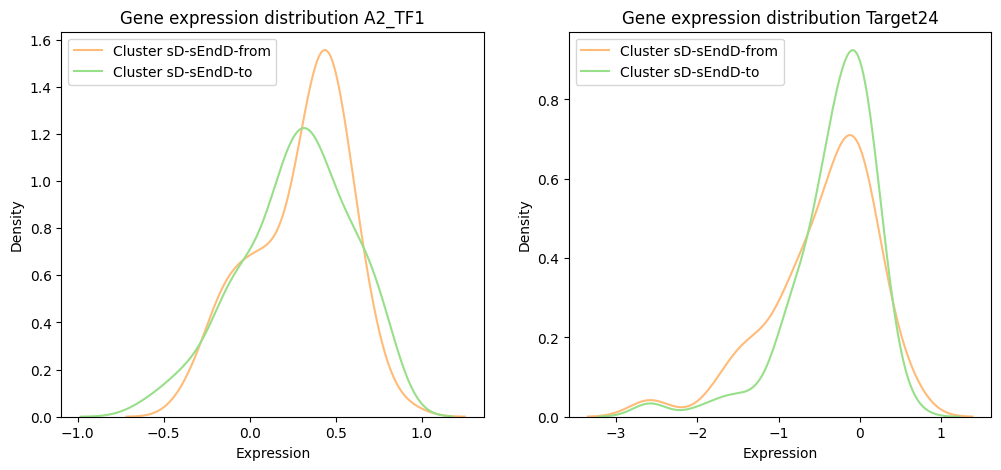

Weight: -10.69809


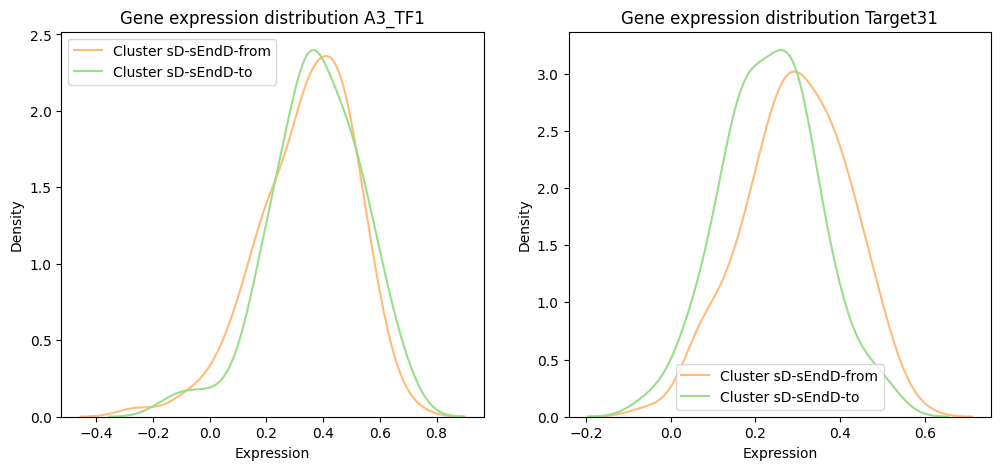

Weight: 65.710579


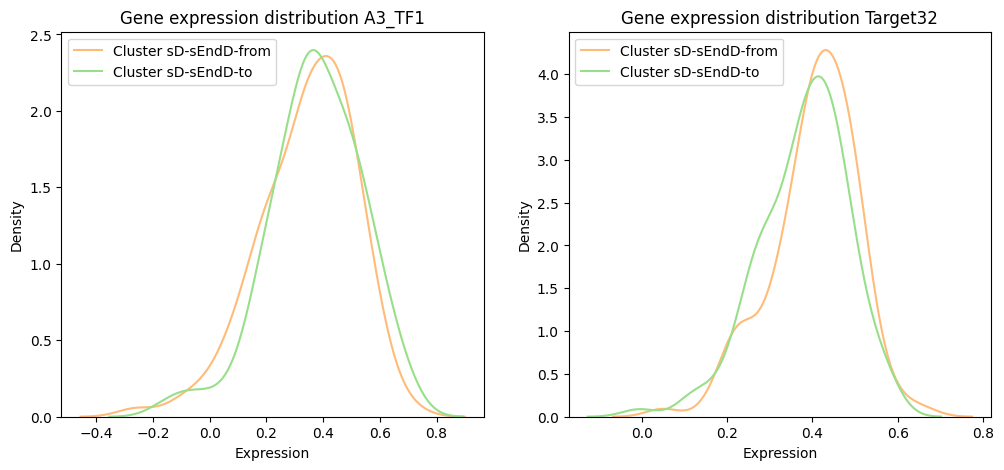

Weight: 6.729065


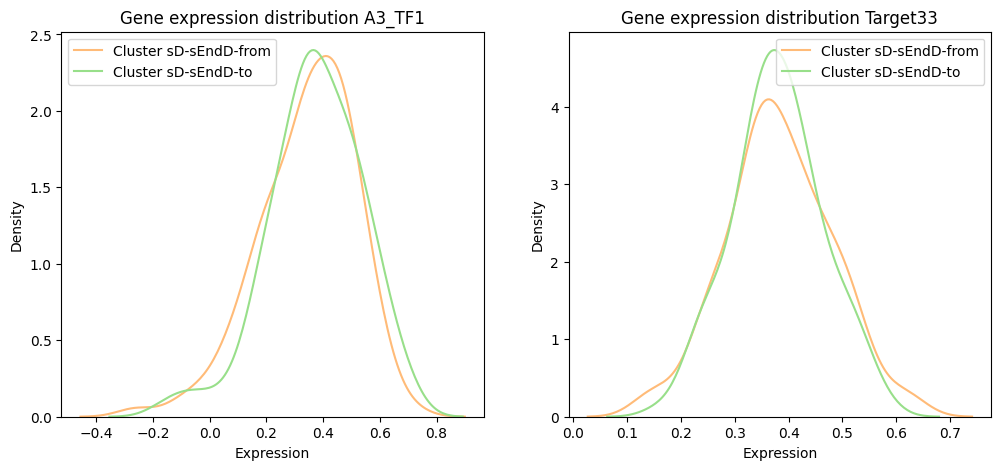

Weight: 16.714112


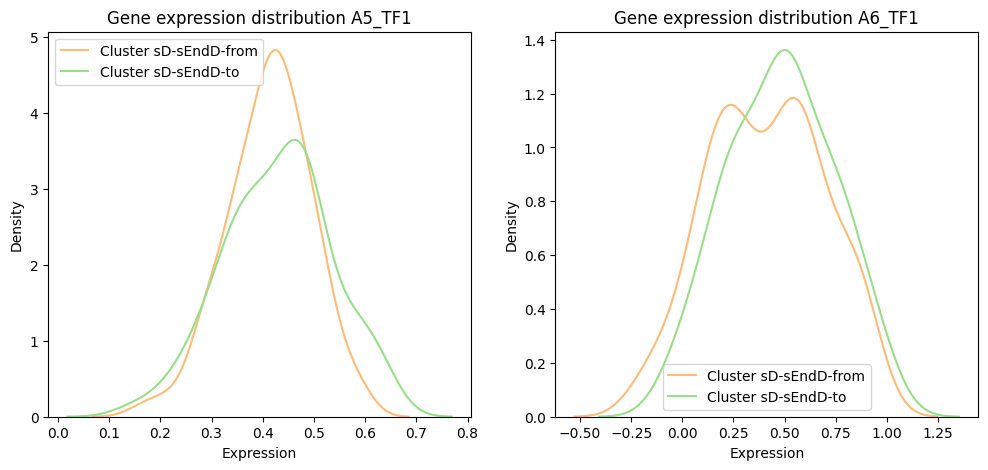

Weight: 1.0


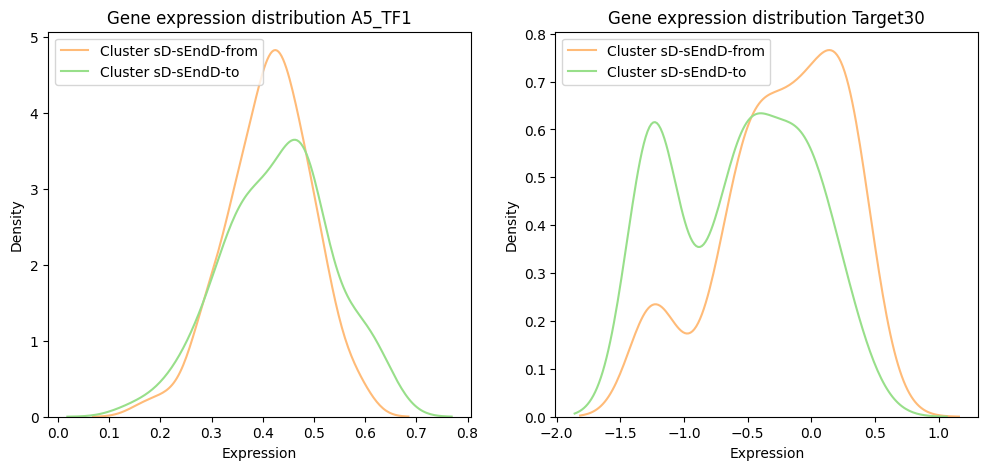

Weight: -24.883327


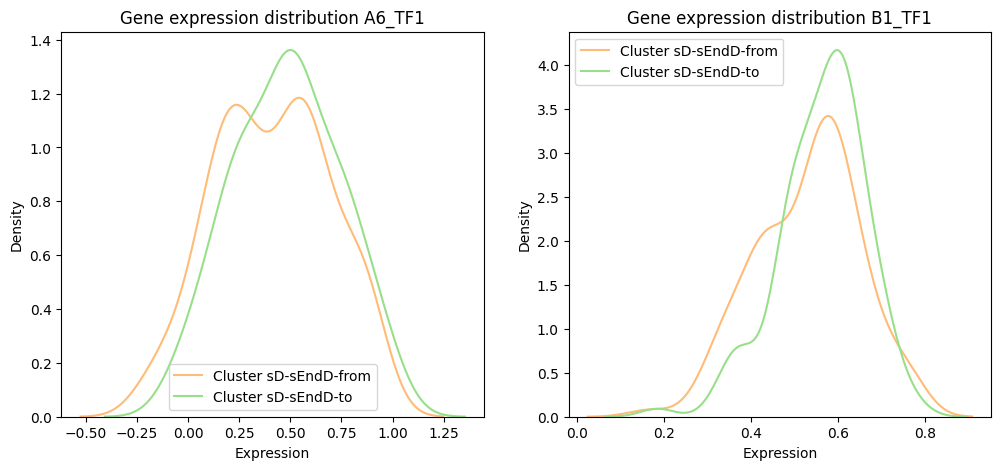

Weight: 1.0


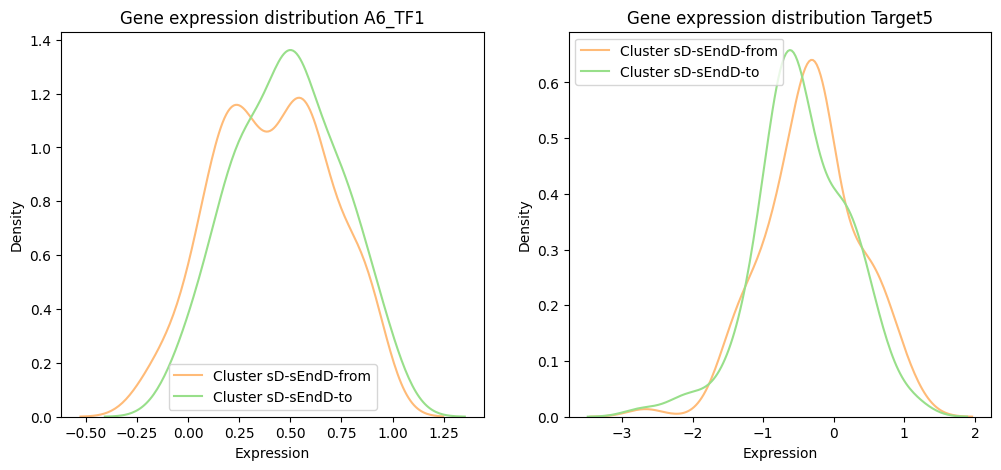

Weight: -1.315294


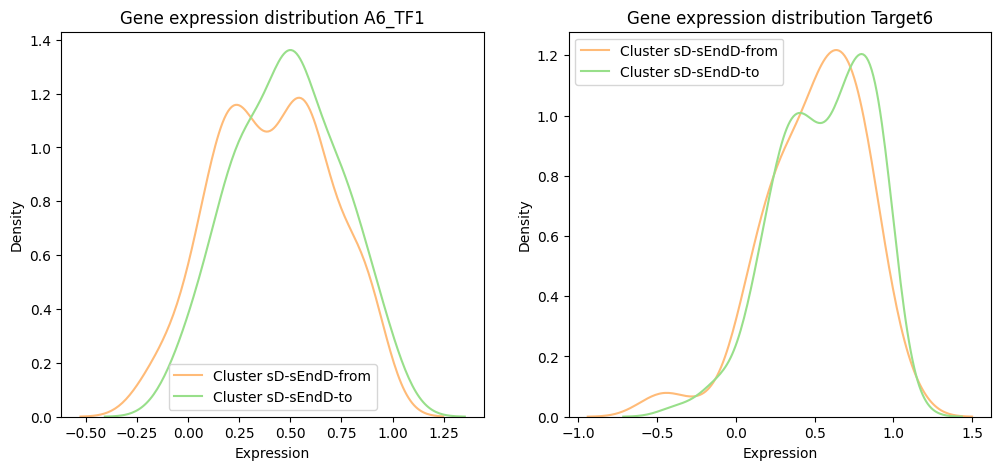

Weight: 1.05886


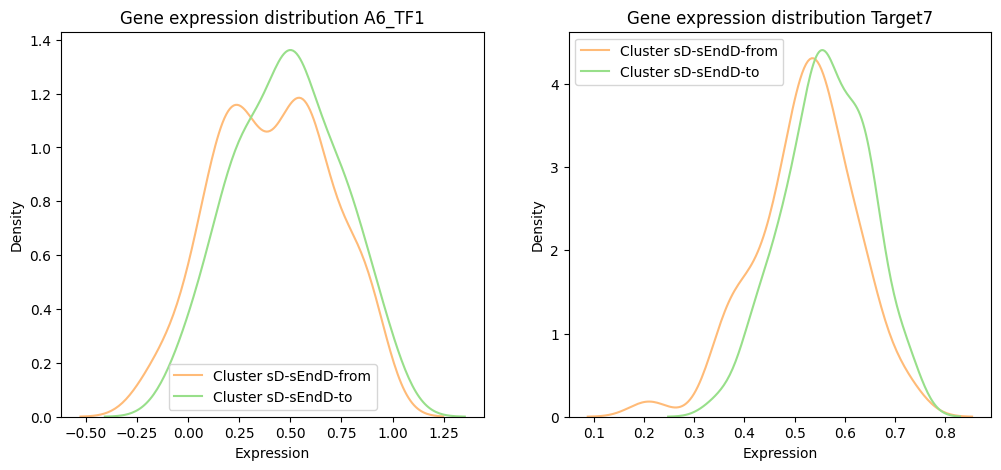

Weight: 1.825841


In [34]:
from plotting import display_gene_expression_distribution


clusters = ["sD-sEndD-from", "sD-sEndD-to"]
activated_genes = np.nonzero(transition_grn)
for driver_index, target_index in zip(*activated_genes):
    driver_gene_name = df_cells.columns[driver_index]
    target_gene_name = df_cells.columns[target_index]

    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    display_gene_expression_distribution(adata, driver_gene_name, clusters=clusters, ax=axes[0])
    display_gene_expression_distribution(adata, target_gene_name, clusters=clusters, ax=axes[1])
    
    plt.show()

    weight = transition_grn[driver_index, target_index]
    print(f"Weight: {weight}")


In [35]:
df_cells = adata.to_df()
clusters = adata.obs["cluster"]

In [36]:
grouped = df_cells.groupby(clusters)
statistics = grouped.aggregate(["mean", "var"])

interesting_genes = ["A1_TF1","Target10"]
display(statistics[interesting_genes])

/tmp/ipykernel_212452/705209665.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_cells.groupby(clusters)


A1_TF1            Target10          
                   mean       var      mean       var
cluster                                              
sA-sB-from    -0.946428  6.409770 -1.113573  0.000000
sA-sB-to       0.186294  0.126086 -1.113573  0.000000
sB-sBmid-from  0.098855  0.037824 -1.113573  0.000000
sB-sBmid-to    0.062485  0.087145 -1.113573  0.000000
sBmid-sC-from  0.180686  0.085081 -1.059266  0.058405
sBmid-sC-to    0.059151  0.116628  0.118292  0.719748
sBmid-sD-from  0.139937  0.154500 -0.922202  0.266306
sBmid-sD-to    0.141179  0.117197  0.819971  0.072640
sC-sEndC-from  0.011560  0.070120  0.906168  0.002367
sC-sEndC-to   -0.015257  0.079016  0.919712  0.004430
sD-sEndD-from  0.216035  0.088608  0.958165  0.003652
sD-sEndD-to    0.253096  0.078125  0.949221  0.004070